<a href="https://colab.research.google.com/github/harrybaines/ml-resources/blob/main/chapter-notebooks/ch12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 12: Parallelizing Neural Network Training with PyTorch

Reference: Machine Learning with PyTorch and scikit-learn (https://github.com/rasbt/machine-learning-book)

In [1]:
import torch
import numpy as np
np.set_printoptions(precision=3)

In [2]:
print(torch.__version__)

1.12.1+cu113


## Creating tensors

In [3]:
a = [1, 2, 3]
b = np.array([4, 5, 6], dtype=np.int32)

t_a = torch.tensor(a)
t_b = torch.from_numpy(b)

print(t_a, t_a.shape)
print(t_b)

tensor([1, 2, 3]) torch.Size([3])
tensor([4, 5, 6], dtype=torch.int32)


In [4]:
t_ones = torch.ones(2, 3)
t_ones, t_ones.shape

(tensor([[1., 1., 1.],
         [1., 1., 1.]]), torch.Size([2, 3]))

In [5]:
rand_tensor = torch.rand(2, 3)
rand_tensor

tensor([[0.5320, 0.8753, 0.1586],
        [0.4353, 0.1750, 0.0460]])

## Manipulating data type and shape of tensors

In [6]:
# Convert data type of tensor
t_a_new = t_a.to(torch.int64)
print(t_a_new.dtype)

torch.int64


In [7]:
# Transpose a tensor
t = torch.rand(3, 5)
t_tr = torch.transpose(t, 0, 1) # swap dim0 (0) and dim1 (1)
print(t.shape, ' --> ', t_tr.shape)

torch.Size([3, 5])  -->  torch.Size([5, 3])


In [8]:
# Reshape a tensor
t = torch.zeros(30)
print('before:', t.shape)
t_reshape = t.reshape(5, 6)
print('after:', t_reshape.shape)

before: torch.Size([30])
after: torch.Size([5, 6])


In [9]:
# Remove unnecessary dimensions (i.e. dimensions with size 1, not needed)
t = torch.zeros(1, 2, 1, 4, 1)
t_sqz = torch.squeeze(t, 4) # squeeze at specific dimension (otherwise remove all 1 dimensions)
print(t.shape, t_sqz.shape)

torch.Size([1, 2, 1, 4, 1]) torch.Size([1, 2, 1, 4])


### Mathematical operations on tensors

In [10]:
torch.manual_seed(1)

In [11]:
t1 = 2 * torch.rand(5, 2) - 1 # uniformly distributed random numbers [0,1)
t2 = torch.normal(mean=0, std=1, size=(5, 2)) # standard normal distribution

In [12]:
t1

tensor([[ 0.5153, -0.4414],
        [-0.1939,  0.4694],
        [-0.9414,  0.5997],
        [-0.2057,  0.5087],
        [ 0.1390, -0.1224]])

In [13]:
t2

tensor([[ 0.8590,  0.7056],
        [-0.3406, -1.2720],
        [-1.1948,  0.0250],
        [-0.7627,  1.3969],
        [-0.3245,  0.2879]])

In [14]:
t3 = torch.multiply(t1, t2) # element-wise product (same as torch.mul)
t3

tensor([[ 0.4426, -0.3114],
        [ 0.0660, -0.5970],
        [ 1.1249,  0.0150],
        [ 0.1569,  0.7107],
        [-0.0451, -0.0352]])

In [15]:
t4 = torch.mean(t1, axis=0)
t4

tensor([-0.1373,  0.2028])

In [16]:
t4 = torch.sum(t1, axis=0) # axis=0: mean down the columns, axis=1: mean across the rows
t4

tensor([-0.6867,  1.0140])

In [17]:
t4 = torch.std(t1, axis=0)
t4

tensor([0.5378, 0.4591])

In [18]:
t5 = torch.matmul(t1, torch.transpose(t2, 0, 1)) # matrix-matrix product (t1 * t2.T), (5x2)*(2x5)=5x5
t5

tensor([[ 0.1312,  0.3860, -0.6267, -1.0096, -0.2943],
        [ 0.1647, -0.5310,  0.2434,  0.8035,  0.1980],
        [-0.3855, -0.4422,  1.1399,  1.5558,  0.4781],
        [ 0.1822, -0.5771,  0.2585,  0.8676,  0.2132],
        [ 0.0330,  0.1084, -0.1692, -0.2771, -0.0804]])

In [19]:
torch.transpose(t2, 0, 1)

tensor([[ 0.8590, -0.3406, -1.1948, -0.7627, -0.3245],
        [ 0.7056, -1.2720,  0.0250,  1.3969,  0.2879]])

In [20]:
t6 = torch.matmul(torch.transpose(t1, 0, 1), t2) # (2x5)*(5x2)=2x2
t6

tensor([[ 1.7453,  0.3392],
        [-1.6038, -0.2180]])

In [21]:
norm_t1 = torch.linalg.norm(t1, ord=2, dim=1) # L^p norm of tensor (dim=1: horizontal)
norm_t1

tensor([0.6785, 0.5078, 1.1162, 0.5488, 0.1853])

In [22]:
np.sqrt(np.sum(np.square(t1.numpy()), axis=1)) # equivalent to before

array([0.678, 0.508, 1.116, 0.549, 0.185], dtype=float32)

In [23]:
((0.5153*0.5153)+(-0.4414*-0.4414))**0.5

0.6785042741206573

### Split, stack and concatenate tensors

In [24]:
torch.manual_seed(1)
t = torch.rand(6)
t_splits = torch.chunk(t, 3) # create n equally sized tensors (last chunk may be smaller if not evenly divisible)
[item.numpy() for item in t_splits] # or just t_splits

[array([0.758, 0.279], dtype=float32),
 array([0.403, 0.735], dtype=float32),
 array([0.029, 0.8  ], dtype=float32)]

In [25]:
t = torch.rand(5)
t_splits = torch.split(t, split_size_or_sections=[3, 2]) # split tensor of size 5 into chunks of 3 and 2
[item.numpy() for item in t_splits]

[array([0.397, 0.754, 0.57 ], dtype=float32),
 array([0.439, 0.639], dtype=float32)]

In [26]:
A = torch.ones(3)
B = torch.zeros(2)
C = torch.cat([A, B], axis=0) # concatenate along horizontal
C

tensor([1., 1., 1., 0., 0.])

In [27]:
A = torch.ones(3)
B = torch.zeros(3)
S = torch.stack([A, B], axis=1) # stack on top of each other vertically
S

tensor([[1., 0.],
        [1., 0.],
        [1., 0.]])

### PyTorch DataLoader from existing tensors

In [28]:
from torch.utils.data import DataLoader
t = torch.arange(6, dtype=torch.float32)
data_loader = DataLoader(t)

In [29]:
for item in data_loader:
    print(item)

tensor([0.])
tensor([1.])
tensor([2.])
tensor([3.])
tensor([4.])
tensor([5.])


In [30]:
# can iterate through dataset directly but DataLoader provides customisable batching
data_loader = DataLoader(t, batch_size=3, drop_last=False) # don't drop last non-full batch (defaults to False)
for i, batch in enumerate(data_loader, 1): # create batches of size 3
    print(f'batch {i}:', batch)

batch 1: tensor([0., 1., 2.])
batch 2: tensor([3., 4., 5.])


### Combine tensors into joint dataset

In [31]:
torch.manual_seed(1)
t_x = torch.rand([4, 3], dtype=torch.float32)
t_y = torch.arange(4)

In [32]:
from torch.utils.data import Dataset

class JointDataset(Dataset):
    def __init__(self, x, y): # required for data loader later on
        self.x = x
        self.y = y

    def __getitem__(self, idx): # required for data loader later on
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [33]:
joint_dataset = JointDataset(t_x, t_y) # preserves element-wise correspondence
for example in joint_dataset:
    print(f'x: {example[0]}, y: {example[1]}')

x: tensor([0.7576, 0.2793, 0.4031]), y: 0
x: tensor([0.7347, 0.0293, 0.7999]), y: 1
x: tensor([0.3971, 0.7544, 0.5695]), y: 2
x: tensor([0.4388, 0.6387, 0.5247]), y: 3


### Shuffle, batch and repeat

In [34]:
data_loader = DataLoader(
    dataset=joint_dataset, batch_size=2, shuffle=True) # shuffle rows without losing one-to-one correspondence

In [35]:
for i, batch in enumerate(data_loader, 1):
    print(f'batch {i}: \n \t x: {batch[0]} \n \t y: {batch[1]}')

batch 1: 
 	 x: tensor([[0.7576, 0.2793, 0.4031],
        [0.4388, 0.6387, 0.5247]]) 
 	 y: tensor([0, 3])
batch 2: 
 	 x: tensor([[0.3971, 0.7544, 0.5695],
        [0.7347, 0.0293, 0.7999]]) 
 	 y: tensor([2, 1])


In [36]:
# different batches for each epoch, each iteration has elements shuffled within a batch as well
for epoch in range(2):
    print(f'epoch {epoch+1}')
    for i, batch in enumerate(data_loader, 1):
        print(f'batch {i}: \n \t x: {batch[0]} \n \t y: {batch[1]}')

epoch 1
batch 1: 
 	 x: tensor([[0.7347, 0.0293, 0.7999],
        [0.4388, 0.6387, 0.5247]]) 
 	 y: tensor([1, 3])
batch 2: 
 	 x: tensor([[0.3971, 0.7544, 0.5695],
        [0.7576, 0.2793, 0.4031]]) 
 	 y: tensor([2, 0])
epoch 2
batch 1: 
 	 x: tensor([[0.4388, 0.6387, 0.5247],
        [0.3971, 0.7544, 0.5695]]) 
 	 y: tensor([3, 2])
batch 2: 
 	 x: tensor([[0.7347, 0.0293, 0.7999],
        [0.7576, 0.2793, 0.4031]]) 
 	 y: tensor([1, 0])


### Create dataset from files on local storage disk

In [37]:
import pathlib
imgdir_path = pathlib.Path('cat_dog_images')
file_list = sorted([str(path) for path in imgdir_path.glob("*.jpg")])
file_list

['cat_dog_images/cat-01.jpg',
 'cat_dog_images/cat-02.jpg',
 'cat_dog_images/cat-03.jpg',
 'cat_dog_images/dog-01.jpg',
 'cat_dog_images/dog-02.jpg',
 'cat_dog_images/dog-03.jpg']

Image shape: (900, 1200, 3)
Image shape: (900, 1200, 3)
Image shape: (900, 742, 3)
Image shape: (800, 1200, 3)
Image shape: (800, 1200, 3)
Image shape: (900, 1200, 3)


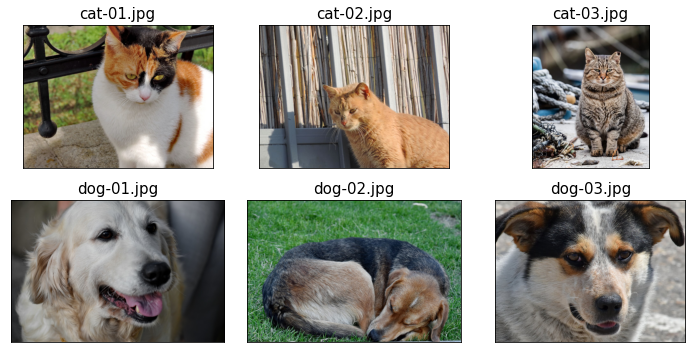

In [38]:
import matplotlib.pyplot as plt
import os
from PIL import Image
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(file_list):
    img = Image.open(file)
    print(f'Image shape: {np.array(img).shape}') # need to be preprocessed to consistent size
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)
plt.tight_layout()
plt.show()

In [39]:
labels = [1 if 'dog' in os.path.basename(file) else 0 for file in file_list]
labels

[0, 0, 0, 1, 1, 1]

In [40]:
# create joint dataset
class ImageDataset(Dataset):
    def __init__(self, file_list, labels):
        self.file_list = file_list
        self.labels = labels

    def __getitem__(self, index):
        file = self.file_list[index]
        label = self.labels[index]
        return file, label

    def __len__(self):
        return len(self.labels)

In [41]:
image_dataset = ImageDataset(file_list, labels)
for file, label in image_dataset:
    print(file, label)

cat_dog_images/cat-01.jpg 0
cat_dog_images/cat-02.jpg 0
cat_dog_images/cat-03.jpg 0
cat_dog_images/dog-01.jpg 1
cat_dog_images/dog-02.jpg 1
cat_dog_images/dog-03.jpg 1


In [42]:
# apply transformations: convert pixels to tensors and resize images
import torchvision.transforms as transforms
img_height, img_width = 80, 120
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width))
])

In [43]:
# update ImageDataset with new transform
class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

In [44]:
image_dataset = ImageDataset(file_list, labels, transform)

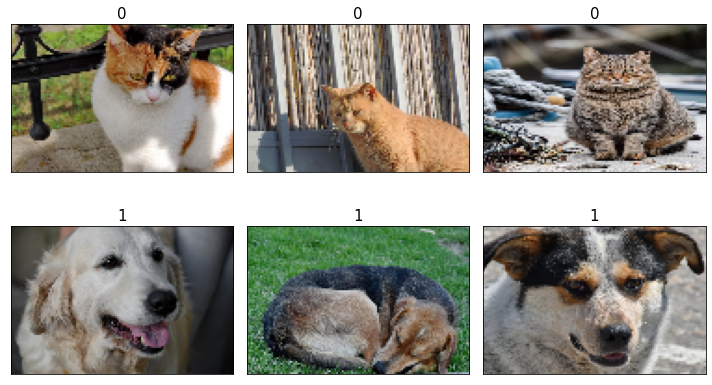

In [45]:
fig = plt.figure(figsize=(10, 6))
for i, example in enumerate(image_dataset):
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    # transpose array so index 1 of original becomes 0 axis of new, index 2 of original becomes 1 axis of new etc
    ax.imshow(example[0].numpy().transpose((1, 2, 0))) # needs to be NxMx3 for RGB image
    ax.set_title(f'{example[1]}', size=15)
plt.tight_layout()
plt.show()

## torchvision.datasets CelebA dataset

In [46]:
import torchvision

In [47]:
image_path = './'

In [48]:
celeba_dataset = torchvision.datasets.CelebA(
    image_path, split='train', target_type='attr', download=True)

Files already downloaded and verified


In [49]:
assert isinstance(celeba_dataset, torch.utils.data.Dataset)

In [50]:
example = next(iter(celeba_dataset))

In [51]:
example

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x7F7B76203A50>,
 tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]))

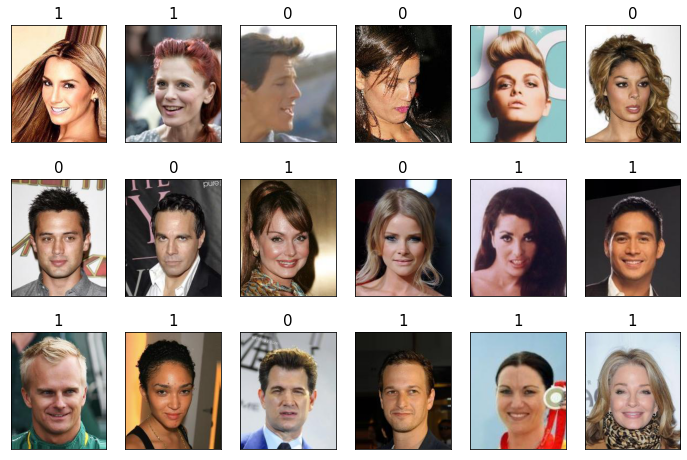

In [52]:
# visualise 'smiling' labels
from itertools import islice
fig = plt.figure(figsize=(12, 8))
for i, (image, attributes) in islice(enumerate(celeba_dataset), 18): # show first 18
    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image)
    ax.set_title(f'{attributes[31]}', size=15)
plt.show()

## torchvision.datasets MNIST dataset

In [53]:
mnist_dataset = torchvision.datasets.MNIST(
    image_path, 'train', download=True)

In [54]:
assert isinstance(mnist_dataset, torch.utils.data.Dataset)

In [55]:
example = next(iter(mnist_dataset))

In [56]:
example

(<PIL.Image.Image image mode=L size=28x28 at 0x7F7B7075F9D0>, 5)

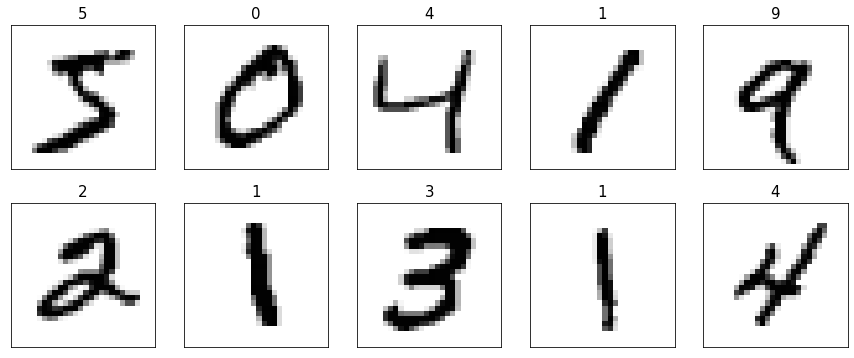

In [57]:
fig = plt.figure(figsize=(15, 6))
for i, (image, label) in islice(enumerate(mnist_dataset), 10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}', size=15)
plt.show()

## Building an NN model in PyTorch

In [58]:
# linear regression
X_train = np.arange(10, dtype='float32').reshape((10, 1))

In [59]:
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0], dtype='float32')

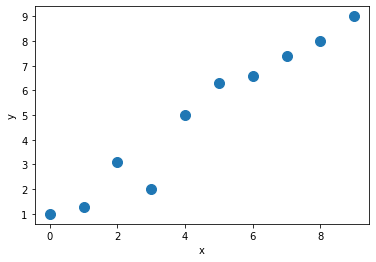

In [60]:
plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [61]:
# standardize features and create PyTorch Dataset and DataLoader
from torch.utils.data import TensorDataset

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(y_train)
train_ds = TensorDataset(X_train_norm, y_train)
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [62]:
torch.manual_seed(1)
weight = torch.randn(1)
weight.requires_grad_()
bias = torch.zeros(1, requires_grad=True)
def model(xb):
    return xb @ weight + bias

In [63]:
# MSE loss
def loss_fn(input, target):
    return (input - target).pow(2).mean()

In [64]:
# SGD to learn weight parameters
learning_rate = 0.001
num_epochs = 200
log_epochs = 10
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
    with torch.no_grad():
        weight -= weight.grad * learning_rate
        bias -= bias.grad * learning_rate
        weight.grad.zero_()
        bias.grad.zero_()
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch} Loss {loss.item():.4f}')

Epoch 0 Loss 46.5720
Epoch 10 Loss 27.1502
Epoch 20 Loss 1.6446
Epoch 30 Loss 14.4571
Epoch 40 Loss 11.7827
Epoch 50 Loss 6.4122
Epoch 60 Loss 0.6339
Epoch 70 Loss 3.1562
Epoch 80 Loss 2.0100
Epoch 90 Loss 0.3107
Epoch 100 Loss 0.7625
Epoch 110 Loss 1.0024
Epoch 120 Loss 0.0232
Epoch 130 Loss 0.5138
Epoch 140 Loss 0.0741
Epoch 150 Loss 1.8712
Epoch 160 Loss 0.0007
Epoch 170 Loss 0.0850
Epoch 180 Loss 0.0634
Epoch 190 Loss 0.0012


In [65]:
print('Final Parameters:', weight.item(), bias.item())

Final Parameters: 2.670930862426758 4.88258695602417


In [66]:
X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train) # apply same standardization to test data!
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()

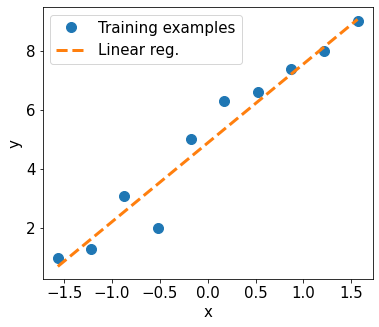

In [67]:
fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3) # learned parameters fixed for prediction, hence straight line fitted (linear regression)
plt.legend(['Training examples', 'Linear reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

## Model training using `torch.nn` and `torch.optim`

In [68]:
import torch.nn as nn

loss_fn = nn.MSELoss(reduction='mean')
input_size = 1
output_size = 1
model = nn.Linear(input_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [69]:
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # Predict
        pred = model(x_batch)[:, 0]
        # Calculate loss
        loss = loss_fn(pred, y_batch)
        # Compute gradients
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        # Reset gradients to zero
        optimizer.zero_grad()
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch} Loss {loss.item():.4f}')

Epoch 0 Loss 24.6684
Epoch 10 Loss 29.1377
Epoch 20 Loss 20.9207
Epoch 30 Loss 0.1257
Epoch 40 Loss 12.4922
Epoch 50 Loss 1.7845
Epoch 60 Loss 7.6425
Epoch 70 Loss 2.5606
Epoch 80 Loss 0.0157
Epoch 90 Loss 0.7548
Epoch 100 Loss 0.8412
Epoch 110 Loss 0.4923
Epoch 120 Loss 0.0823
Epoch 130 Loss 0.0794
Epoch 140 Loss 0.0891
Epoch 150 Loss 0.0973
Epoch 160 Loss 0.1043
Epoch 170 Loss 0.1103
Epoch 180 Loss 0.0009
Epoch 190 Loss 0.0764


In [70]:
print('Final Parameters:', model.weight.item(), model.bias.item())

Final Parameters: 2.6496422290802 4.87706995010376


## MLP for Iris flower classification

In [71]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [72]:
iris = load_iris()
X = iris['data']
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [73]:
# standardize features
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) 

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [74]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [75]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
model = Model(input_size, hidden_size, output_size)

In [76]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [77]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

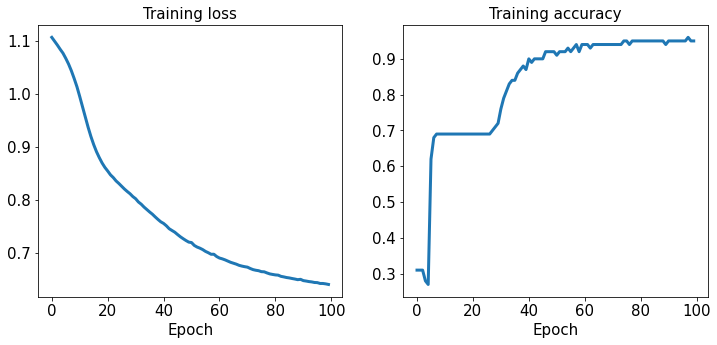

In [78]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

## Evaluate trained model on test dataset

In [79]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train) # apply same standardization to test data
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


## Saving and reloading trained model

In [80]:
path = 'iris_classifier.pt'
torch.save(model, path) # saves model architecture and learned parameters

In [81]:
model_new = torch.load(path) # load model
model_new.eval() # verify model architecture

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [82]:
# verify results are the same as before
pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


In [83]:
# save only learned parameters
path = 'iris_classifier_state.pt'
torch.save(model.state_dict(), path)

In [84]:
# load learned parameters from disk
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>

## Choosing activation functions for multilayer NN's

In [85]:
# can have linear activation like AdaLine, or any differentiable function, but ideally want non linearity
# to solve complex problems (sum of linear funcs = linear func anyway)

In [86]:
# tanh preferred
# sigmoid values close to 0 can result in NN learning slowly, more likely to get trapped in local minima

## Logistic function

In [87]:
# logistic function = special case of a sigmoid function

In [88]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print(f'P(y=1|x) = {logistic_activation(X, w):.3f}') 
# 88.8% chance sample x belongs to positive class

P(y=1|x) = 0.888


In [89]:
# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('Net Input: \n', Z)

print('Output Units:\n', y_probas)

# resulting output not useful: output layer of multiple logistic functions doesn't produce meaningful
# probability values as they don't sum to 1, but can be usef to predict only class labels, just not
# class membership probabilities

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.856 0.681 0.839]


In [90]:
# predict class label from output units
y_class = np.argmax(Z, axis=0) # argmax gets class label
print('Predicted class label:', y_class) 

Predicted class label: 0


## Estimating class probabilities in multiclass classification via softmax

In [91]:
# softmax: soft form of argmax (gives probability of each class instead of single class index)
# useful for multiclass settings (multinomial logistic regression)

In [92]:
# softmax: normalized output useful for obtaining meaningful class-membership predictions in
# multiclass settings
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas) # predicted class label same as argmax

np.sum(y_probas) 

Probabilities:
 [0.447 0.161 0.392]


1.0

In [93]:
torch.softmax(torch.from_numpy(Z), dim=0)

tensor([0.4467, 0.1611, 0.3922], dtype=torch.float64)

## `tanh` activation

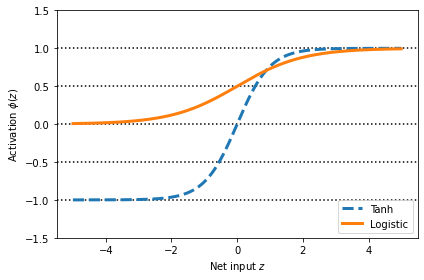

In [94]:
# tanh: rescaled version of logistic function
# has broader output spectrum (-1,1) which can improve convergence
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()

#plt.savefig('figures/12_10.pdf')
plt.show()

In [95]:
np.tanh(z)

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [96]:
torch.tanh(torch.from_numpy(z))

tensor([-0.9999, -0.9999, -0.9999,  ...,  0.9999,  0.9999,  0.9999],
       dtype=torch.float64)

In [97]:
from scipy.special import expit

expit(z) # logistic function from scipy

array([0.007, 0.007, 0.007, ..., 0.993, 0.993, 0.993])

In [98]:
torch.sigmoid(torch.from_numpy(z)) # results equivalent to torch.nn.Sigmoid()(x), torch.sigmoid = function

tensor([0.0067, 0.0067, 0.0068,  ..., 0.9932, 0.9932, 0.9933],
       dtype=torch.float64)

## ReLU activation

In [99]:
# ReLU: nonlinear function
# vanishing gradient problem:
# assume z_1=20, which changes to z_2=25
# tanh(z_1)=1, tanh(z_2)=1 (no change in output: asymptotic behaviour of tanh)
# z becomes large: derivative of activations wrt input diminishes (think of curve)
# therefore learning weights is slower as gradient terms may be close to 0
# ReLU fixes this problem
# derivative always 1 for +ve inputs

In [100]:
torch.relu(torch.from_numpy(z))

tensor([0.0000, 0.0000, 0.0000,  ..., 4.9850, 4.9900, 4.9950],
       dtype=torch.float64)